1. IMPORT LIBRARIES

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2. LOAD DATASET AND INITIAL EXPLORATION

In [68]:
df = pd.read_csv("Loan Prediction Dataset.csv")

In [69]:
# Display first few rows 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [70]:
# Display missing value counts
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [71]:
# Define numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)


Numerical Columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


3. DATA PREPROCESSING

In [72]:
# Fill missing values: numerical with mean, categorical with mode
df[num_cols] = df[num_cols].apply(lambda col: col.fillna(col.mean()))
df[cat_cols] = df[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))

print("\nMissing Values After Imputation:")
df.isnull().sum()


Missing Values After Imputation:


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [73]:
# Display summary statistics
print("\nDataset Summary Statistics:")
df.describe()


Dataset Summary Statistics:


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.000000,0.842199
std,6109.041673,2926.248369,84.037468,64.372489,0.349681
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [74]:
# Display data info
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


4. DATA VISUALIZATION

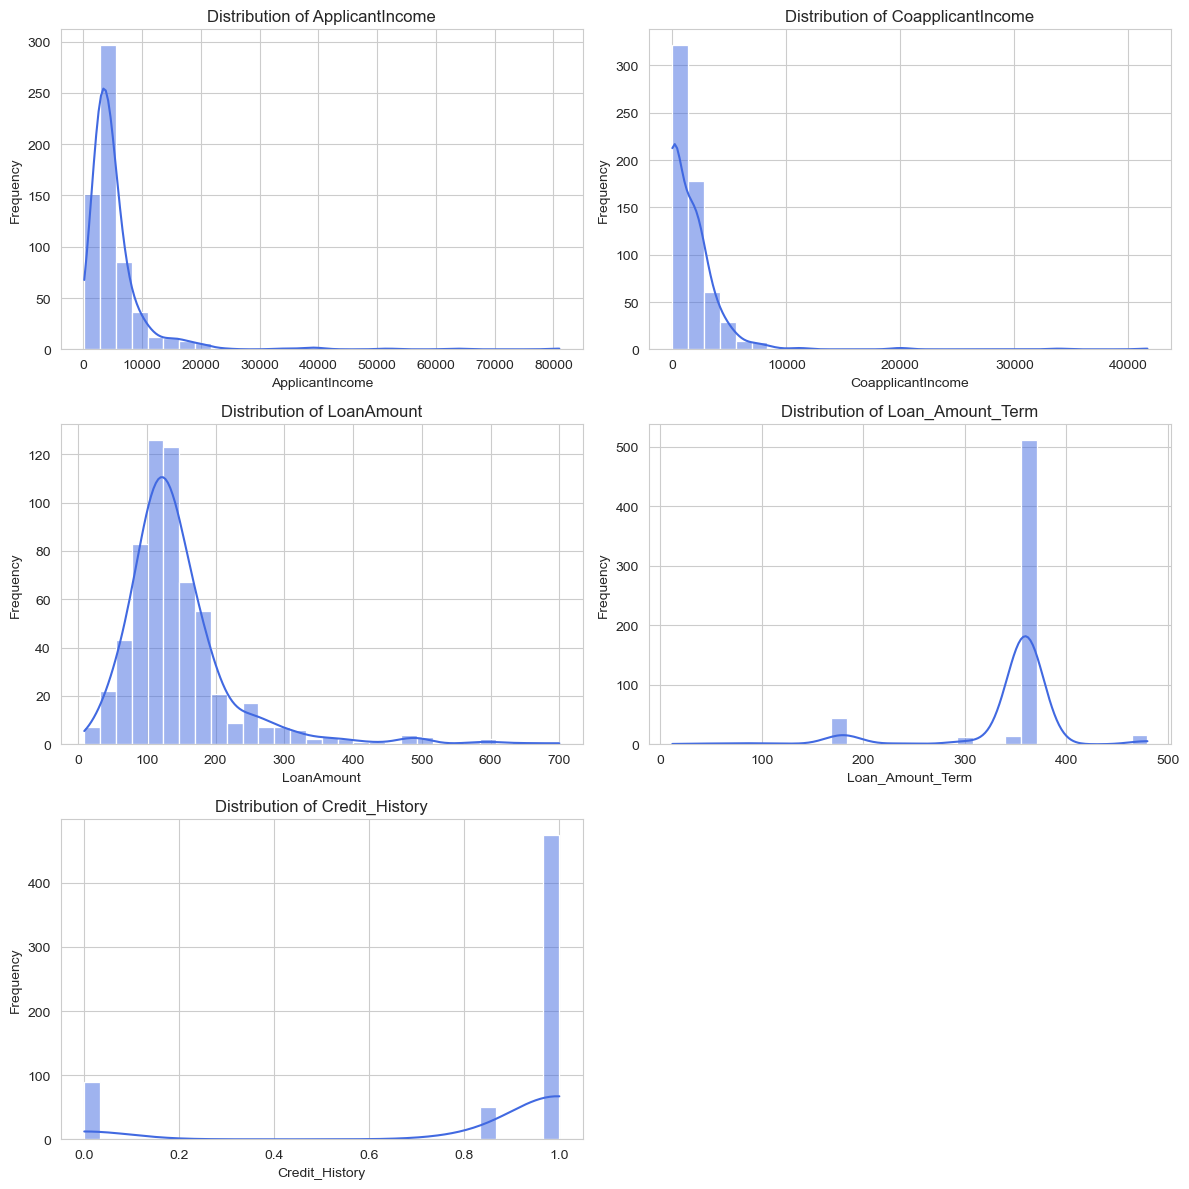

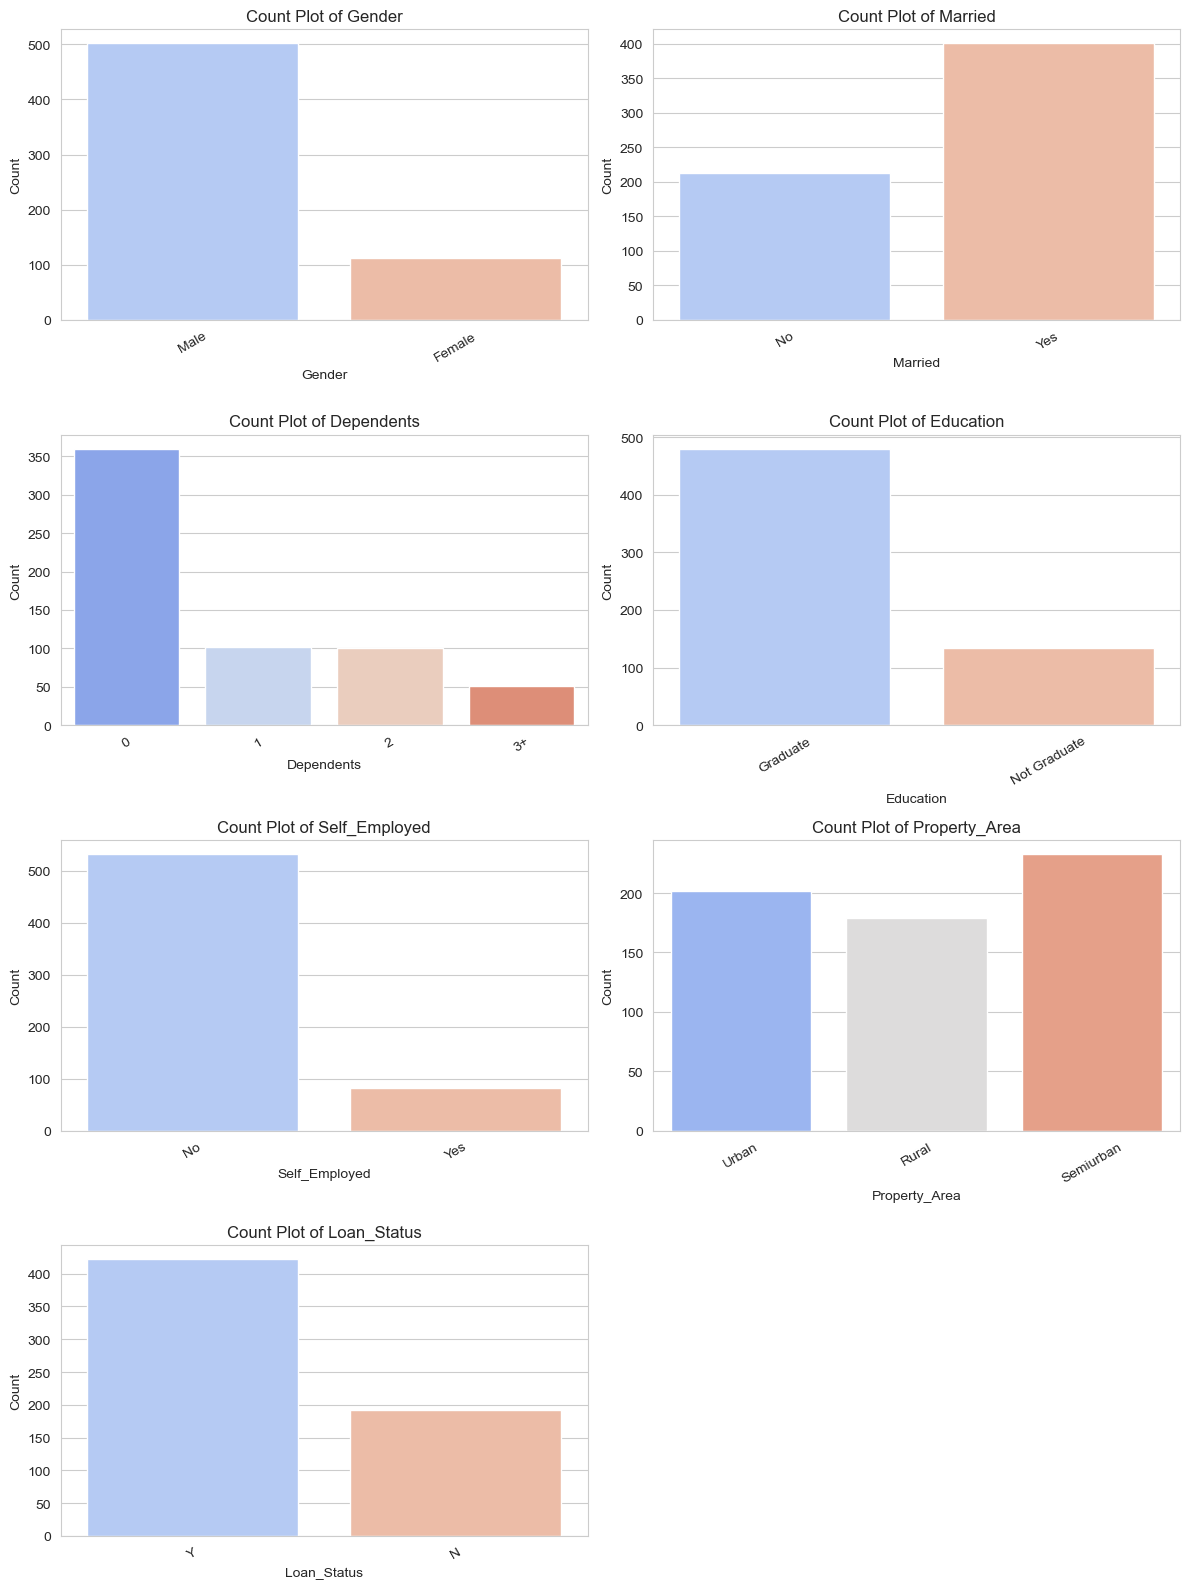

In [75]:
# Close any previous plots and set Seaborn style
plt.close('all')
sns.set_style("whitegrid")

# Exclude 'Loan_ID' from categorical columns (if present)
if 'Loan_ID' in cat_cols:
    cat_cols.remove('Loan_ID')

# 4a. Visualize Numerical Columns in a 2-Column Grid
n_num = len(num_cols)
ncols = 2
nrows_num = math.ceil(n_num / ncols)
fig, axes = plt.subplots(nrows=nrows_num, ncols=ncols, figsize=(12, nrows_num * 4))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=True, color='royalblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

# 4b. Visualize Categorical Columns in a 2-Column Grid
n_cat = len(cat_cols)
nrows_cat = math.ceil(n_cat / ncols)
fig, axes = plt.subplots(nrows=nrows_cat, ncols=ncols, figsize=(12, nrows_cat * 4))
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], hue=df[col], palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Count Plot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=30)
# Hide extra axes if needed
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

5. CATEGORICAL VARIABLE ENCODING USING LABEL ENCODER

In [76]:
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

6. DEFINE FEATURES & TARGET

In [77]:
features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
            'Credit_History', 'Gender', 'Married', 'Dependents',
            'Education', 'Self_Employed', 'Property_Area']
target = ['Loan_Status']

# Keep only the required columns
df = df[features + target]

# Define X and y
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

7. SPLIT DATA INTO TRAING & TESTINGSET

In [78]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y )

In [79]:
# Standardize only the numerical features
num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

8. ---- Logistic Regression -----

Training Logistic Regression
Logistic Regression Accuracy: 0.8536585365853658
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.58      0.71        38
           1       0.84      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.88      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123



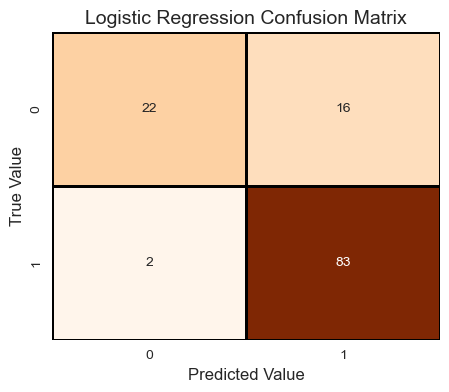

In [80]:

print("Training Logistic Regression")
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

# Print model performance
print("Logistic Regression Accuracy:", lr_accuracy)
print("Classification Report:\n", classification_report(y_test, lr_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, lr_pred))

# ---- Confusion Matrix Visualization ----
cm = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", linewidths=2, linecolor="black", cbar=False)

# Add labels and title
plt.xlabel("Predicted Value", fontsize=12)
plt.ylabel("True Value", fontsize=12)
plt.title("Logistic Regression Confusion Matrix", fontsize=14)

plt.show()


9. ---- Random Forest -----

In [81]:
# ----- Hyperparameter Tuning for Random Forest -----

print("===== Hyperparameter Tuning for Random Forest =====")

# Define an extended parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],         # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]                 # Whether bootstrap samples are used when building trees
}

# Create a baseline Random Forest model for tuning
rf_model_for_tuning = RandomForestClassifier(random_state=42)

# Perform GridSearchCV to tune hyperparameters with the extended grid
grid_search_rf = GridSearchCV(rf_model_for_tuning, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Retrieve the best model from grid search
rf_best_model = grid_search_rf.best_estimator_

# Print the best hyperparameters and tuned accuracy
print("Random Forest - Best Hyperparameters:")
print(grid_search_rf.best_params_)
print("Random Forest - Accuracy after Tuning:",
      accuracy_score(y_test, rf_best_model.predict(X_test)))
print("=" * 60 + "\n")


===== Hyperparameter Tuning for Random Forest =====
Random Forest - Best Hyperparameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - Accuracy after Tuning: 0.8536585365853658



===== Training Random Forest Classifier =====
Random Forest Accuracy: 0.8537

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        38
           1       0.85      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123



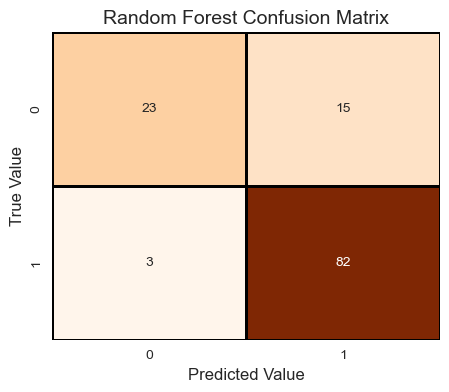

In [82]:
# Retrieve the best model from grid search
rf_best_model = grid_search_rf.best_estimator_

# Predict on test data
y_pred_rf = rf_best_model.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Generate classification report
rf_classification_report = classification_report(y_test, y_pred_rf)

# Generate confusion matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Print formatted output similar to Logistic Regression
print("===== Training Random Forest Classifier =====")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(rf_classification_report)

# Plot confusion matrix similar to Logistic Regression
plt.figure(figsize=(5, 4))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Oranges", linewidths=2, linecolor="black", cbar=False)

plt.title("Random Forest Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Value", fontsize=12)
plt.ylabel("True Value", fontsize=12)

plt.show()

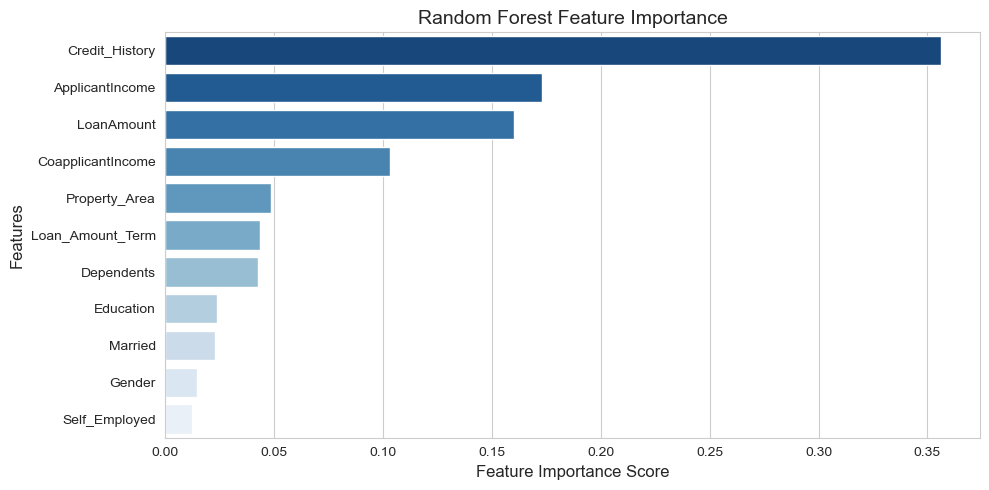

In [83]:
# Get feature importance from the already trained best model
feature_importance = rf_best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store feature importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    hue="Feature", 
    dodge=False, 
    palette="Blues_r"
)
# Safely remove the legend if it exists
if ax.get_legend() is not None:
    ax.get_legend().remove()

plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Random Forest Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()

10. ----- XGBoost -----

===== Hyperparameter Tuning for XGBoost =====
XGBoost - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
XGBoost - Accuracy after Tuning: 0.8536585365853658

===== Training XGBoost =====
XGBoost Accuracy: 0.8048780487804879
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68        38
           1       0.86      0.86      0.86        85

    accuracy                           0.80       123
   macro avg       0.77      0.77      0.77       123
weighted avg       0.80      0.80      0.80       123



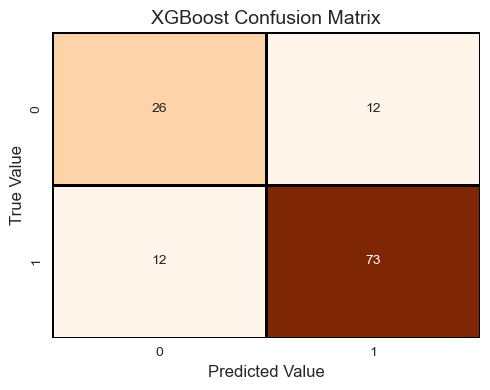

In [84]:
# ----- Hyperparameter Tuning for XGBoost -----

print("===== Hyperparameter Tuning for XGBoost =====")

# Define the parameter grid for tuning
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Perform GridSearchCV to tune hyperparameters
xgb_best_model = XGBClassifier(eval_metric='logloss')
grid_search_xgb = GridSearchCV(xgb_best_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Retrieve the best model from grid search
xgb_best_model = grid_search_xgb.best_estimator_

# Print the best hyperparameters and tuned accuracy
print("XGBoost - Best Hyperparameters:", grid_search_xgb.best_params_)
print("XGBoost - Accuracy after Tuning:", accuracy_score(y_test, xgb_best_model.predict(X_test)))
print("=" * 60 + "\n")


# Train XGBoost Model & Evaluate Performance

print("===== Training XGBoost =====")
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Print performance metrics
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print("XGBoost Accuracy:", xgb_accuracy)
print("Classification Report:\n", classification_report(y_test, xgb_pred))

# Confusion Matrix Visualization

cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", linewidths=2, linecolor="black", cbar=False)
plt.xlabel("Predicted Value", fontsize=12)
plt.ylabel("True Value", fontsize=12)
plt.title("XGBoost Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()


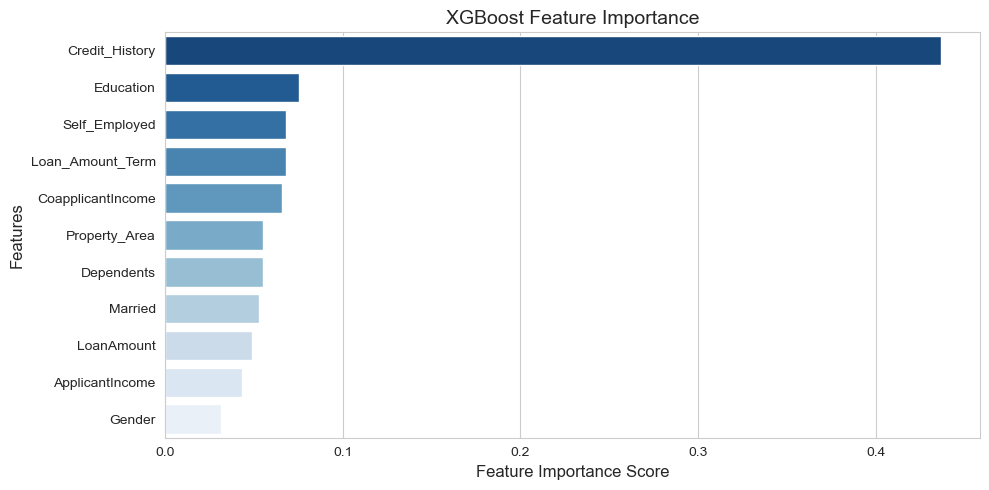

In [85]:
# 📌 Feature Importance Visualization

# Extract feature importance
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance using a horizontal bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, hue="Feature", dodge=False, palette="Blues_r", legend=False)
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("XGBoost Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()